In [1]:
import argparse
import numpy as np
from config import (
    ALL_CLASSES,
    CLASS2LABEL,
    DATA_FILE,
    LABEL,
    PROCESS_SIGNALS,
    SAMPLE_SIZE,
    SAVE_INTERMEDIATE_RESULTS,
    DEFAULT_TRAINING_TIME_LGB,
    DEFAULT_TRAINING_TIME_PERCEPTRON,
    MODELS_TO_PLOT,
    RECALL_RELEVANT_CLASSES,
)
from deep_net import train_neural_net
from lgb_model import train_lgb_model
from load_data import load_data
from matplotlib import pyplot as plt
from snippets import plot_confusion_matrix, plot_feature_importance, plot_training_progress

Using TensorFlow backend.


In [2]:
train_set, test_set = load_data(DATA_FILE, 100000, PROCESS_SIGNALS)

features = list(train_set)
features.remove(LABEL)
y_true = test_set[LABEL]

C:\Users\Magda\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Magda\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Magda\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Magda\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Magda\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.

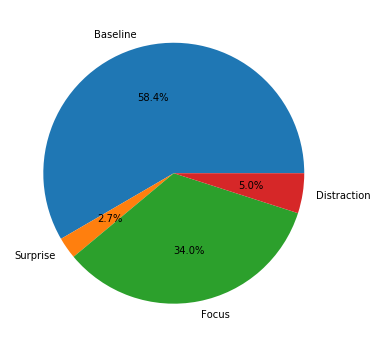

In [3]:
from config import CLASS2LABEL
from snippets import count_class_occurences, plot_class_shares
    
class2counts = count_class_occurences(train_set[LABEL], ALL_CLASSES)   
counts = [class2counts[key] for key in class2counts.keys()]
labels = [CLASS2LABEL[key] for key in class2counts.keys()]

plot_class_shares(counts, labels)

AttributeError: module 'matplotlib.pyplot' has no attribute 'setup'

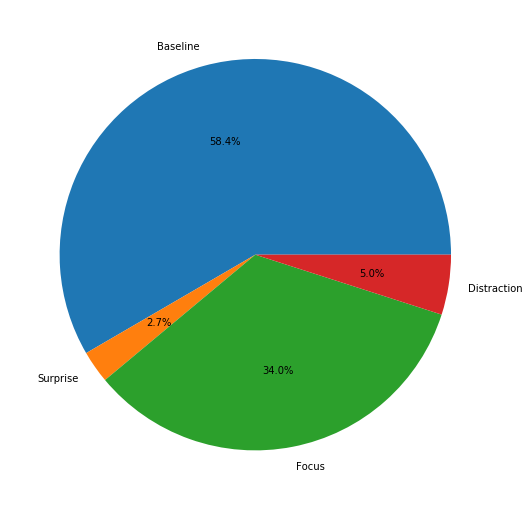

In [11]:
plt.figure(figsize=(18, 9))
plt.pie(counts, labels = labels, autopct='%1.1f%%')
plt.setup(autotexts, size='big')

In [6]:
from numpy import ndarray
from keras.models import Model
import tensorflow as tf

def calculate_recall(y_true: ndarray, y_pred: ndarray, epsilon: float = tf.keras.backend.epsilon()) -> List[float]:

    true_positives = np.sum(np.multiply(y_true, y_pred), axis=0)
    possible_positives = np.sum(y_true, axis=0) # cache it
    recall = true_positives / (possible_positives + epsilon) # cache it

    return recall, true_positives, possible_positives

def aggregate_recall(recalls: List[float], weights: List[float]) -> float:
    
    aggregated_recall = 0
    for weight, recall in zip(recalls, weights):
        aggregated_recall += weight*recall
    
    return aggregated_recall    

def calculate_single_metric(x: ndarray, y: ndarray, model: Model, weights: List[float]) -> float:
    
    predicted = model.predict(x)
    predicted = tf.keras.utils.to_categorical(predicted.argmax(axis=1), num_classes=predicted.shape[1])
    
    recalls = calculate_recall(y, predicted)
    recall = aggregate_recall(recalls,weights)
    
    return recall

In [7]:
EPOCHS = 2

import random
from time import time

import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
from config import (BATCH_NORM, BATCH_SIZE, BETA_1, BETA_2,
                    INPUT_LAYERS, MODEL_FILE, PARAM_FILE,
                    PARAM_RANGE_PERCEPTRON)
from keras import Model
from numpy import ndarray
from pandas import DataFrame
from sklearn.metrics import accuracy_score
from snippets import get_random_parameters
from typing import List, Tuple
import json
from keras import backend as K
from sklearn.utils import class_weight

train_metric = []
test_metric = []
learning_rate = []
lr_decay = []
deep_layers = []

features = list(train_set)
features.remove(LABEL)
num_class = len(np.unique(train_set[LABEL]))

model_index = 0
timeout = time() + 1

Y_TRUE_TRAIN = tf.keras.utils.to_categorical(train_set[LABEL])
Y_TRUE_TEST = tf.keras.utils.to_categorical(test_set[LABEL])
METRIC_WEIGHTS = [0, 
           counts[1] / (counts[1]+counts[3]), 
           0, 
           counts[3] / (counts[1]+counts[3])]
weights = class_weight.compute_class_weight('balanced', CLASSES, train_set[LABEL])
CLASS_WEIGHT = dict(zip(CLASSES,weights))

while time() < timeout:

    learning_rate.append(0.01)
    lr_decay.append(1e-6)
    deep_layers.append(10)

    # instantiate model
    model = tf.keras.models.Sequential()

    # Input layers
    model.add(layers.Dense(INPUT_LAYERS, input_dim=train_set[features].shape[1]))
    if BATCH_NORM:
        model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    # Intermediary layers
    model.add(layers.Dense(deep_layers[model_index]))
    if BATCH_NORM:
        model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    # Output layer
    model.add(layers.Dense(num_class))
    if BATCH_NORM:
        model.add(layers.BatchNormalization())
    model.add(layers.Activation('softmax'))
 
    adam_optimizer = tf.keras.optimizers.Adam(lr=learning_rate[model_index],
                                              decay=lr_decay[model_index],
                                              beta_1=BETA_1,
                                              beta_2=BETA_2,
                                              epsilon=None,
                                              amsgrad=False)
    model.compile(optimizer=adam_optimizer,
                  loss='categorical_crossentropy',
                  weighted_metrics=["accuracy"])
    
    curr_model = model.fit(train_set[features], Y_TRUE_TRAIN, class_weight = CLASS_WEIGHT, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

    recall_train = calculate_single_metric(train_set[features], Y_TRUE_TRAIN, model, METRIC_WEIGHTS)
    train_metric.append(recall_train)

    recall_test = calculate_single_metric(test_set[features], Y_TRUE_TEST, model, METRIC_WEIGHTS)
    test_metric.append(recall_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
3893936/3893936 [==============================] - 15s 4us/sample - loss: 1.0500 - weighted_acc: 0.5056
Epoch 2/2
3893936/3893936 [==============================] - 15s 4us/sample - loss: 0.8544 - weighted_acc: 0.6137


In [8]:
predicted = model.predict(train_set[features])
predicted = tf.keras.utils.to_categorical(predicted.argmax(axis=1), num_classes=predicted.shape[1])    

recalls = calculate_recall(Y_TRUE_TRAIN, predicted)
recall = aggregate_recall(recalls, METRIC_WEIGHTS)    

Normalized confusion matrix
[[0.12864279 0.34274399 0.15766096 0.37095226]
 [0.08374356 0.80584021 0.0884843  0.02193192]
 [0.04312033 0.04260368 0.88146826 0.03280773]
 [0.0996595  0.00884457 0.19791661 0.69357932]]


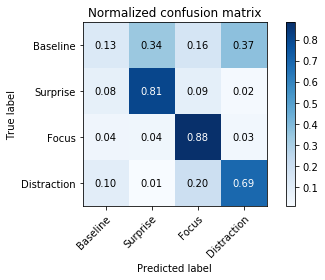

In [9]:
predicted = np.argmax(model.predict(train_set[features]), axis=1)
plot_confusion_matrix(train_set[LABEL], predicted, [CODE2LABEL[code] for code in CLASSES], normalize = True)

Normalized confusion matrix
[[0.12902603 0.34282273 0.15726068 0.37089057]
 [0.07875339 0.80876905 0.09040217 0.02207539]
 [0.04375421 0.04261727 0.88060573 0.03302279]
 [0.09673308 0.00921874 0.19918008 0.69486809]]


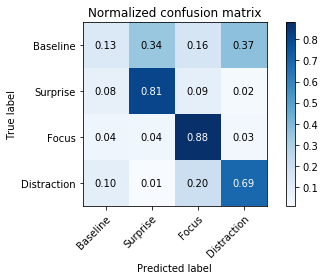

In [10]:
predicted = np.argmax(model.predict(test_set[features]), axis=1)
plot_confusion_matrix(test_set[LABEL], predicted, [CODE2LABEL[code] for code in CLASSES], normalize = True)

In [11]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', CLASSES, train_set[LABEL])
CLASS_WEIGHT = dict(zip(CLASSES,weights))

weights_train = [CLASS_WEIGHT[row] for row in train_set[LABEL]]
weights_test = [CLASS_WEIGHT[row] for row in test_set[LABEL]]

In [12]:
############################################# LIGHT GBM ##########################################################
from config import (BAGGING_FRACTION, EARLY_STOPPING_ROUND, FEATURE_FRACTION,
                     MIN_CHILD_WEIGHT, NUM_BOOST_ROUND, NUM_CLASS,
                     PARAM_RANGE_LGB)

from time import time

import lightgbm as lgb
import numpy as np
from lightgbm import Booster
from numpy import ndarray
from pandas import DataFrame
from sklearn.metrics import accuracy_score
from snippets import get_random_parameters
from typing import Tuple, List


params = {
    "objective": "multiclass",
    "num_class": NUM_CLASS,
    "metric": "multi_error",
    "min_child_weight": MIN_CHILD_WEIGHT,
    "bagging_fraction": BAGGING_FRACTION,
    "feature_fraction": FEATURE_FRACTION,
    "num_leaves": 10,
    "max_bin": 5,
    "learning_rate": 0.01,
    "bagging_seed": 420,
    "verbosity": -1
}

lgb_train = lgb.Dataset(train_set[features], train_set[LABEL], weight=weights_train)
lgb_test = lgb.Dataset(test_set[features], test_set[LABEL], weight=weights_test)

#model = lgb.LGBMClassifier(params)
#model.fit(train_set[features], train_set[LABEL], eval_set=[(test_set[features], test_set[LABEL])], early_stopping_rounds=EARLY_STOPPING_ROUND, verbose=True)
curr_model = lgb.train(params, lgb_train, valid_sets=lgb_test,num_boost_round=NUM_BOOST_ROUND,early_stopping_rounds=EARLY_STOPPING_ROUND,verbose_eval=True)
#predicted = np.argmax(curr_model.predict(train_set[features], num_iteration=curr_model.best_iteration), axis = 1)
#train_acc.append(accuracy_score(train_set[label], predicted))

#predicted = np.argmax(curr_model.predict(test_set[features], num_iteration=curr_model.best_iteration), axis = 1)
#test_acc.append(accuracy_score(test_set[label], predicted))

[1]	valid_0's multi_error: 0.578361
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's multi_error: 0.497864
[3]	valid_0's multi_error: 0.489293
[4]	valid_0's multi_error: 0.457969
[5]	valid_0's multi_error: 0.456525
[6]	valid_0's multi_error: 0.450699
[7]	valid_0's multi_error: 0.452068
[8]	valid_0's multi_error: 0.447426
[9]	valid_0's multi_error: 0.456176
[10]	valid_0's multi_error: 0.464469
[11]	valid_0's multi_error: 0.458179
[12]	valid_0's multi_error: 0.456486
[13]	valid_0's multi_error: 0.461365
[14]	valid_0's multi_error: 0.458758
[15]	valid_0's multi_error: 0.462797
[16]	valid_0's multi_error: 0.463356
[17]	valid_0's multi_error: 0.460611
[18]	valid_0's multi_error: 0.462766
[19]	valid_0's multi_error: 0.46008
[20]	valid_0's multi_error: 0.461144
[21]	valid_0's multi_error: 0.461839
[22]	valid_0's multi_error: 0.46176
[23]	valid_0's multi_error: 0.464995
[24]	valid_0's multi_error: 0.460724
[25]	valid_0's multi_error: 0.459235
[26]	valid_0's multi_err

Normalized confusion matrix
[[0.14663914 0.34375834 0.12089128 0.38871125]
 [0.10264907 0.77647633 0.09135748 0.02951711]
 [0.06205639 0.16785718 0.5650591  0.20502733]
 [0.09673787 0.07672735 0.10875374 0.71778105]]


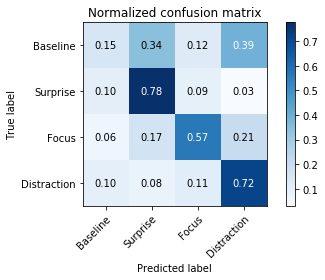

In [13]:
predicted = np.argmax(curr_model.predict(train_set[features], num_iteration=curr_model.best_iteration), axis=1)
plot_confusion_matrix(train_set[LABEL], predicted, [CODE2LABEL[code] for code in CLASSES], normalize = True)

Normalized confusion matrix
[[0.14538386 0.34421339 0.12095949 0.38944326]
 [0.10121071 0.77790933 0.09177711 0.02910285]
 [0.06219932 0.16759648 0.56450496 0.20569924]
 [0.09341943 0.07617146 0.10888313 0.72152598]]


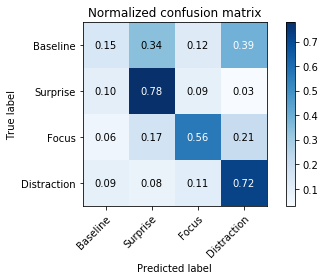

In [14]:
predicted = np.argmax(curr_model.predict(test_set[features], num_iteration=curr_model.best_iteration), axis=1)
plot_confusion_matrix(test_set[LABEL], predicted, [CODE2LABEL[code] for code in CLASSES], normalize = True)